# Notebook to Investigate LSTM Performance Variance for Montane Using Stop Function

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {}
run_dict["mon_mse_stop_95"] = "a77f2789f59f46d5afcaa9e1c7889fb6"
run_dict["mon_cust_stop_95.001"] = "f9265f0811d84854917e6ce1c77e19ac"
run_dict["mon_cust_stop_95.004"] = "4b084c14922141c0bd02e40a02d0002e"
run_dict["mon_custom_stop.95.01"] = "a56437e43c3147ae8ce0f839f7b2283f" # enthused grub
run_dict["mon_cust_stop_95.04"] = "0cf9e5852574406ba13dcfc41f3d8915"
run_dict["mon_kge_only_stop_95"] = "3cbfb85c7c3f40ed8f0c61b054e23571"
run_dict["mon_stop_95_30"] = "f91b6cbc8342468da44763fda1e953a1"
run_dict["mon_custom_stop_95_.04_30"] = "cda8d91a9f4d4d638ddfab364ecf3cf4"

run_dict["mon_mse_stop_97"] = "04b6699f82824c3bb9a5a658e03243cf" # gregarious colt
run_dict["mon_mse_stop_97_run2"] = "def58263cd5649e9b0a1d4ffbf0d1757"
run_dict["mon_mse_stop_97_run3"] = "e9d2e71b69d749c5bf82a383f22b88d0"
run_dict["mon_cust_stop_97.001"] = "4bcfb4b8cbfc455281294bed32e9b6d7"
run_dict["mon_custom_stop_97.04"] = "093484b9f34f4051a67e112eb92eef73"
run_dict["mon_custome_stop_.97.04_30"] = "be9c2ef2fc5e4220af7daf2e8c7fb1ba"


run_dict["mon_mse_stop_98_30"] = "ca6d9487796d460e9d4cba3fac9d6e2d"




run_dict

{'mon_mse_stop_95': 'a77f2789f59f46d5afcaa9e1c7889fb6',
 'mon_cust_stop_95.001': 'f9265f0811d84854917e6ce1c77e19ac',
 'mon_cust_stop_95.004': '4b084c14922141c0bd02e40a02d0002e',
 'mon_custom_stop.95.01': 'a56437e43c3147ae8ce0f839f7b2283f',
 'mon_cust_stop_95.04': '0cf9e5852574406ba13dcfc41f3d8915',
 'mon_kge_only_stop_95': '3cbfb85c7c3f40ed8f0c61b054e23571',
 'mon_stop_95_30': 'f91b6cbc8342468da44763fda1e953a1',
 'mon_custom_stop_95_.04_30': 'cda8d91a9f4d4d638ddfab364ecf3cf4',
 'mon_mse_stop_97': '04b6699f82824c3bb9a5a658e03243cf',
 'mon_mse_stop_97_run2': 'def58263cd5649e9b0a1d4ffbf0d1757',
 'mon_mse_stop_97_run3': 'e9d2e71b69d749c5bf82a383f22b88d0',
 'mon_cust_stop_97.001': '4bcfb4b8cbfc455281294bed32e9b6d7',
 'mon_custom_stop_97.04': '093484b9f34f4051a67e112eb92eef73',
 'mon_custome_stop_.97.04_30': 'be9c2ef2fc5e4220af7daf2e8c7fb1ba',
 'mon_mse_stop_98_30': 'ca6d9487796d460e9d4cba3fac9d6e2d'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
key = "mon_custome_stop_.97.04_30"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics.head(2)


(15600, 3)


,Metric,Step,Value
0,train_mae_170200090302,0,0.017453
1,train_mae_170200090302,1,0.017625


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

In [8]:
# function to extract only the last epoch 
def filter_to_last_step_per_metric(df):
    """
    Filters the DataFrame to include only rows where 'step' is the maximum for each 'metric'.
    
    Parameters:
        df (pd.DataFrame): A DataFrame with columns 'metric', 'step', and 'value'.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only the last step for each metric.
    """
    return df[df["Step"] == df.groupby("Metric")["Step"].transform("max")]



Examples 

In [9]:
df_kge = extract_metric_by_prefix(df_metrics, "test_kge", step = True)
#df_kge[df_kge["Metric"] == "test_kge_171100051001"]
df_kge.head()

,Metric,Step,Value
9537,test_kge_170103020101,0,0.932334
9694,test_kge_170103020102,0,0.946558
9697,test_kge_170103020102,3,0.918335
9698,test_kge_170103020102,4,0.937482
9699,test_kge_170103020102,5,0.906581


In [10]:
df_kge_last = filter_to_last_step_per_metric(df_kge)
df_kge_last.head()

,Metric,Step,Value
9537,test_kge_170103020101,0,0.932334
9723,test_kge_170103020102,29,0.902349
10731,test_kge_170103020103,29,0.896670
9633,test_kge_170103020201,29,0.821460
10417,test_kge_170103020202,29,0.738018


In [11]:
df_sorted = df_kge_last.sort_values("Value")
df_sorted.head()

,Metric,Step,Value
13267,test_kge_170602071107,1,0.602824
13027,test_kge_170602071105,27,0.604027
3977,test_kge_170300010601,29,0.643234
5833,test_kge_170200100208,29,0.690125
10800,test_kge_170103020303,29,0.691445


In [12]:
df_kge_last.describe()

,Step,Value
count,187.000000,187.000000
mean,9.427807,0.901504
std,11.810733,0.068662
min,0.000000,0.602824
25%,0.000000,0.878749
50%,3.000000,0.923346
75%,19.000000,0.948074
max,29.000000,0.981117


# Step 3- Compare Runs

In [13]:
def assemble_summary(run_dict, metric_nm): 
    df_summary_dict = {}
    for key in run_dict.keys(): 
        df_metrics = df_dict[key]
        df_filtered = extract_metric_by_prefix(df_metrics, metric_nm, step=True)
        df_metric_last = filter_to_last_step_per_metric(df_filtered)

        # Set the index to the 'metric' column
        df_metric_last = df_metric_last.set_index("Metric")

        # Append the key to all other column names (except the index)
        df_metric_last = df_metric_last.add_suffix(f"_{key}")
        df_metric_last.columns = df_metric_last.columns.str.replace("Value", metric_nm)

        # Store in the summary dictionary
        df_summary_dict[key] = df_metric_last

    # Concatenate all DataFrames on the index (metric)
    df_summary = pd.concat(df_summary_dict.values(), axis=1)

    return df_summary


In [14]:
def slim_by_prefix(df, prefix):
    """
    Returns a new DataFrame containing only the columns whose names start with the given prefix.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): Column prefix to filter by (e.g., "Test_KGE").
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only matching columns.
    """
    slim_cols = [col for col in df.columns if col.startswith(prefix)]
    return df[slim_cols].copy()


In [15]:
df_summary = assemble_summary(run_dict, "test_kge")
df_summary.head()

,Step_mon_mse_stop_95,test_kge_mon_mse_stop_95,Step_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.001,Step_mon_cust_stop_95.004,test_kge_mon_cust_stop_95.004,Step_mon_custom_stop.95.01,test_kge_mon_custom_stop.95.01,Step_mon_cust_stop_95.04,test_kge_mon_cust_stop_95.04,...,Step_mon_mse_stop_97_run3,test_kge_mon_mse_stop_97_run3,Step_mon_cust_stop_97.001,test_kge_mon_cust_stop_97.001,Step_mon_custom_stop_97.04,test_kge_mon_custom_stop_97.04,Step_mon_custome_stop_.97.04_30,test_kge_mon_custome_stop_.97.04_30,Step_mon_mse_stop_98_30,test_kge_mon_mse_stop_98_30
Metric,,,,,,,,,,,,,,,,,,,,,
test_kge_170103020101,0,0.860028,5,0.888518,1,0.907909,1,0.940560,0,0.934592,...,1,0.936885,5,0.936702,2,0.933011,0,0.932334,0,0.918426
test_kge_170103020102,2,0.901432,0,0.930452,9,0.927475,9,0.884727,9,0.929955,...,9,0.941660,9,0.915441,9,0.856965,29,0.902349,29,0.919697
test_kge_170103020103,6,0.907718,9,0.840223,1,0.891290,3,0.905504,9,0.918831,...,2,0.934600,9,0.788840,9,0.906855,29,0.896670,29,0.898180
test_kge_170103020201,9,0.835902,9,0.880731,4,0.896078,9,0.719661,9,0.726208,...,9,0.786317,9,0.866831,9,0.755027,29,0.821460,29,0.793291
test_kge_170103020202,9,0.762706,9,0.647967,9,0.658865,9,0.704744,9,0.687009,...,9,0.793032,9,0.752796,9,0.784679,29,0.738018,29,0.817644


In [16]:
df_summary_slim = slim_by_prefix(df_summary, "test_kge")
df_summary_slim.describe()

,test_kge_mon_mse_stop_95,test_kge_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.004,test_kge_mon_custom_stop.95.01,test_kge_mon_cust_stop_95.04,test_kge_mon_kge_only_stop_95,test_kge_mon_stop_95_30,test_kge_mon_custom_stop_95_.04_30,test_kge_mon_mse_stop_97,test_kge_mon_mse_stop_97_run2,test_kge_mon_mse_stop_97_run3,test_kge_mon_cust_stop_97.001,test_kge_mon_custom_stop_97.04,test_kge_mon_custome_stop_.97.04_30,test_kge_mon_mse_stop_98_30
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.899074,0.817899,0.889083,0.874892,0.886238,0.882529,0.896788,0.885190,0.893627,0.896050,0.899657,0.876807,0.879839,0.901504,0.896274
std,0.069074,0.304456,0.099827,0.120294,0.114294,0.076678,0.070720,0.087317,0.074408,0.085552,0.069116,0.100377,0.083786,0.068662,0.069788
min,0.515987,-0.661218,0.104385,0.000556,-0.191694,0.550016,0.548499,0.404663,0.623924,0.196249,0.541850,0.464747,0.500300,0.602824,0.500635
25%,0.878463,0.856911,0.872097,0.861566,0.875771,0.859231,0.874103,0.862536,0.864004,0.870596,0.873015,0.852970,0.856069,0.878749,0.863457
50%,0.916595,0.910185,0.919590,0.905118,0.920448,0.903674,0.916871,0.911259,0.918607,0.919333,0.915063,0.906767,0.901194,0.923346,0.914884
75%,0.944094,0.939569,0.945504,0.936012,0.936005,0.932374,0.942238,0.939695,0.946285,0.944786,0.947455,0.943333,0.934145,0.948074,0.945908
max,0.979904,0.969317,0.976972,0.970650,0.981162,0.971539,0.980497,0.980833,0.973368,0.974728,0.976745,0.972375,0.969674,0.981117,0.976164


# Step 4 - Plot 

In [17]:
def plot_metric_boxplots(df, prefix="test_kGE"):
    """
    Plots boxplots for all columns in the DataFrame that start with the given prefix.
    Uses the remainder of the column name (after the prefix + underscore) as the label.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): The prefix to filter columns by (e.g., 'Test_KGE', 'Test_MSE').
    """
    # Ensure prefix ends with "_" for clean suffix extraction
    prefix = prefix.rstrip("_") + "_"

    # Filter relevant columns
    metric_cols = [col for col in df.columns if col.startswith(prefix)]

    if not metric_cols:
        print(f"No columns found with prefix '{prefix}'")
        return

    # Reshape to long format
    df_long = df[metric_cols].copy()
    df_long = df_long.melt(var_name="Metric", value_name="Value")

    # Clean up the Metric labels
    df_long["Metric"] = df_long["Metric"].str.replace(prefix, "", regex=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_long, x="Metric", y="Value")
    plt.xticks(rotation=45)
    plt.title(f"{prefix.strip('_')} by Strategy")
    plt.tight_layout()
    plt.show()


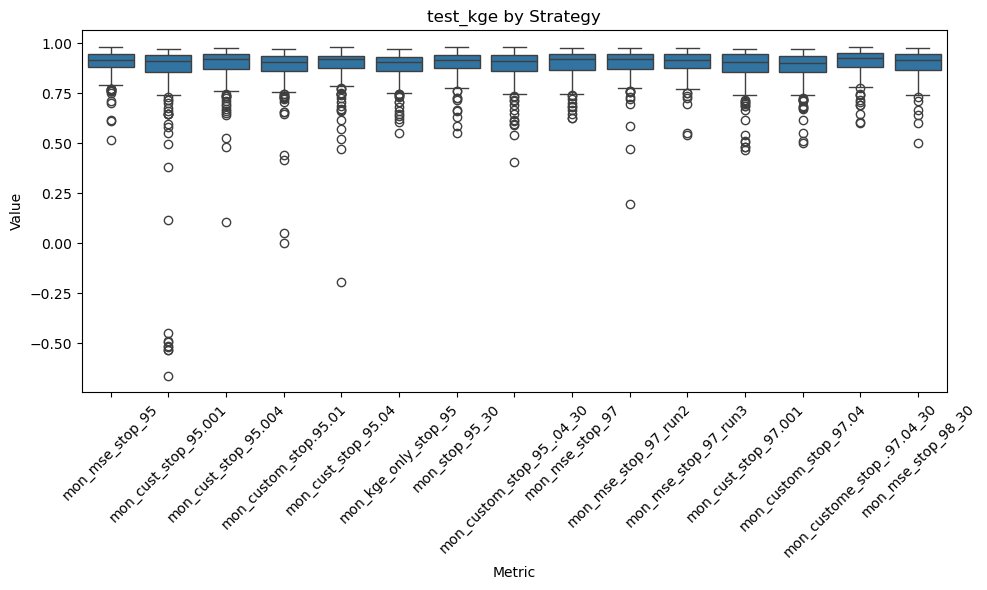

In [18]:
plot_metric_boxplots(df_summary, prefix="test_kge")

# Step 5 Compare to Results By Epoch No_stop Run 

In [19]:
run_dict_no_stop = {}
#run_dict_no_stop["Mon_mse"] = "36b552505bb2495ab5d4fc44f8c87471"
#run_dict_no_stop["Mon_kge"] = "47c8948e441d4101a6a045c422f9ac75"
run_dict_no_stop["Mon_mse_30"] = "7312aaba82904400b4b8a0bed602d47d"
run_dict_no_stop["Mon_kge_30"] = 'f3de511923cd4a6b8befa782e1291880'

In [20]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict_no_stop = {}
for key in run_dict_no_stop.keys(): 
    run_id = run_dict_no_stop[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict_no_stop[key] = df_metrics

In [21]:
df_dict_no_stop.keys()

dict_keys(['Mon_mse_30', 'Mon_kge_30'])

In [22]:

metric_nm = "test_kge"
epochs = 10 
df_summary_all = df_summary

for key in df_dict_no_stop.keys():
    df_metrics = df_dict_no_stop[key]
    df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
    epochs = list(set(df_metrics["Step"]))
    
    for epoch in epochs: 
        df_epoch =  df_filtered[df_filtered["Step"] == epoch]
        # Set the index to the 'metric' column
        df_epoch = df_epoch.set_index("Metric")
        # Append the key to all other column names (except the index)
        df_epoch = df_epoch.add_suffix(f"_{key}_epoch{epoch}")
        df_epoch.columns = df_epoch.columns.str.replace("Value", metric_nm)
        df_summary_all = pd.concat([df_summary_all, df_epoch], axis=1)

df_summary_all.head()



,Step_mon_mse_stop_95,test_kge_mon_mse_stop_95,Step_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.001,Step_mon_cust_stop_95.004,test_kge_mon_cust_stop_95.004,Step_mon_custom_stop.95.01,test_kge_mon_custom_stop.95.01,Step_mon_cust_stop_95.04,test_kge_mon_cust_stop_95.04,...,Step_Mon_kge_30_epoch25,test_kge_Mon_kge_30_epoch25,Step_Mon_kge_30_epoch26,test_kge_Mon_kge_30_epoch26,Step_Mon_kge_30_epoch27,test_kge_Mon_kge_30_epoch27,Step_Mon_kge_30_epoch28,test_kge_Mon_kge_30_epoch28,Step_Mon_kge_30_epoch29,test_kge_Mon_kge_30_epoch29
Metric,,,,,,,,,,,,,,,,,,,,,
test_kge_170103020101,0,0.860028,5,0.888518,1,0.907909,1,0.940560,0,0.934592,...,25,0.753488,26,0.759071,27,0.770492,28,0.764662,29,0.769538
test_kge_170103020102,2,0.901432,0,0.930452,9,0.927475,9,0.884727,9,0.929955,...,25,0.595331,26,0.668224,27,0.671111,28,0.735223,29,0.760766
test_kge_170103020103,6,0.907718,9,0.840223,1,0.891290,3,0.905504,9,0.918831,...,25,0.765156,26,0.778286,27,0.722256,28,0.793248,29,0.807812
test_kge_170103020201,9,0.835902,9,0.880731,4,0.896078,9,0.719661,9,0.726208,...,25,0.728296,26,0.685058,27,0.671707,28,0.651196,29,0.584903
test_kge_170103020202,9,0.762706,9,0.647967,9,0.658865,9,0.704744,9,0.687009,...,25,0.566212,26,0.504813,27,0.592911,28,0.626772,29,0.518510


In [23]:
df_summary_all_slim = slim_by_prefix(df_summary_all, "test_kge")
df_summary_all_slim.describe()

,test_kge_mon_mse_stop_95,test_kge_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.004,test_kge_mon_custom_stop.95.01,test_kge_mon_cust_stop_95.04,test_kge_mon_kge_only_stop_95,test_kge_mon_stop_95_30,test_kge_mon_custom_stop_95_.04_30,test_kge_mon_mse_stop_97,test_kge_mon_mse_stop_97_run2,...,test_kge_Mon_kge_30_epoch20,test_kge_Mon_kge_30_epoch21,test_kge_Mon_kge_30_epoch22,test_kge_Mon_kge_30_epoch23,test_kge_Mon_kge_30_epoch24,test_kge_Mon_kge_30_epoch25,test_kge_Mon_kge_30_epoch26,test_kge_Mon_kge_30_epoch27,test_kge_Mon_kge_30_epoch28,test_kge_Mon_kge_30_epoch29
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,...,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.899074,0.817899,0.889083,0.874892,0.886238,0.882529,0.896788,0.885190,0.893627,0.896050,...,0.826890,0.824857,0.825326,0.825536,0.821194,0.816939,0.815322,0.817885,0.822920,0.821074
std,0.069074,0.304456,0.099827,0.120294,0.114294,0.076678,0.070720,0.087317,0.074408,0.085552,...,0.106547,0.104154,0.102546,0.107999,0.104164,0.119606,0.115918,0.107943,0.103627,0.108974
min,0.515987,-0.661218,0.104385,0.000556,-0.191694,0.550016,0.548499,0.404663,0.623924,0.196249,...,0.419878,0.369114,0.353076,0.297548,0.414442,0.155326,0.280917,0.354646,0.393154,0.333251
25%,0.878463,0.856911,0.872097,0.861566,0.875771,0.859231,0.874103,0.862536,0.864004,0.870596,...,0.767339,0.768360,0.773784,0.773491,0.769605,0.755400,0.757354,0.750238,0.769373,0.762128
50%,0.916595,0.910185,0.919590,0.905118,0.920448,0.903674,0.916871,0.911259,0.918607,0.919333,...,0.856085,0.852260,0.835586,0.857660,0.842167,0.845601,0.841959,0.842037,0.845081,0.844451
75%,0.944094,0.939569,0.945504,0.936012,0.936005,0.932374,0.942238,0.939695,0.946285,0.944786,...,0.907902,0.898920,0.903432,0.898497,0.900210,0.900191,0.894083,0.900100,0.900158,0.897559
max,0.979904,0.969317,0.976972,0.970650,0.981162,0.971539,0.980497,0.980833,0.973368,0.974728,...,0.962996,0.965385,0.970826,0.973607,0.959826,0.961513,0.964213,0.973066,0.966403,0.964921


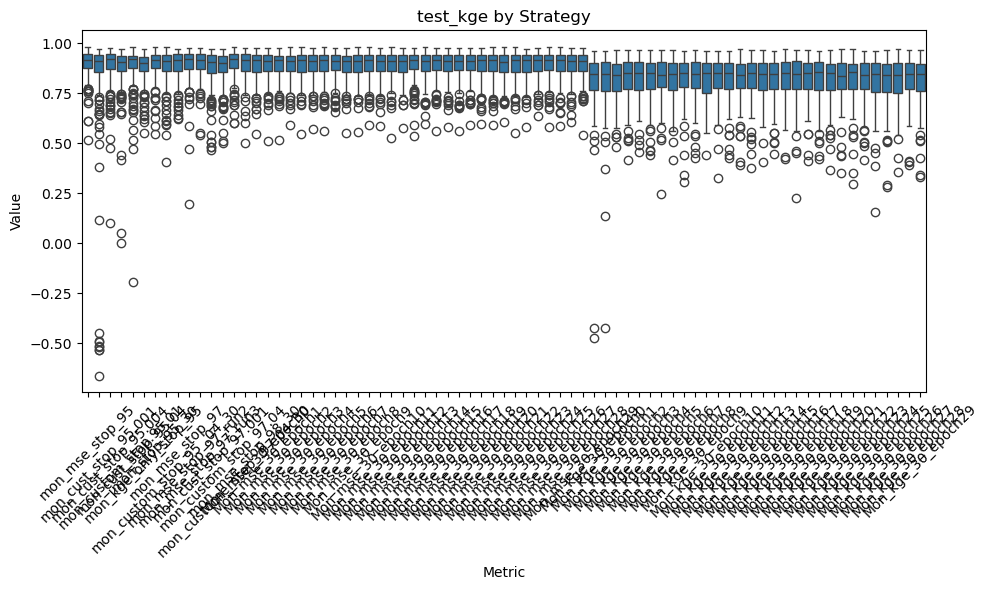

In [24]:
plot_metric_boxplots(df_summary_all, prefix="test_kge")

In [25]:
def filter_dict_by_keys(d, keys):
    return {k: d[k] for k in keys if k in d}


In [26]:
col_to_keep = ["test_kge_mon_mse_stop_97", "test_kge_mon_mse_stop_97_run2", "test_kge_mon_mse_stop_97_run3", "test_kge_mon_cust_stop_95.04", "test_kge_mon_stop_95_30", "test_kge_mon_mse_stop_98_30", "test_kge_Mon_mse_epoch2", "test_kge_Mon_mse_epoch9"]
df_summary_small = df_summary_all[col_to_keep]
df_summary_small.describe()


KeyError: "['test_kge_Mon_mse_epoch2', 'test_kge_Mon_mse_epoch9'] not in index"

In [ ]:
plot_metric_boxplots(df_summary_small, prefix="test_kge")